Compared the results calculated from full covariance and only diagonal terms.

Note: the diagonal data here is calculated by evaluating f1 and f2 separately but not just let off-diagonal terms be 0.

Parameter set:
delta = 0.1; dt=0.1fs; shots=1024; v_init = [-100, 100], pos_init = [0, 0.6]

In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
coords_full = np.loadtxt('../data/H2_delta_0.1_shots_1024_coords_1.5ps_parallel_v1.txt')
velocity_full = np.loadtxt('../data/H2_delta_0.1_shots_1024_velocity_1.5ps_parallel_v1.txt')
coords_diag = np.loadtxt('../data/H2_delta_0.1_shots_1024_coords_1.5ps_parallel_diag_v1.txt')
velocity_diag = np.loadtxt('../data/H2_delta_0.1_shots_1024_velocity_1.5ps_parallel_diag_v1.txt')

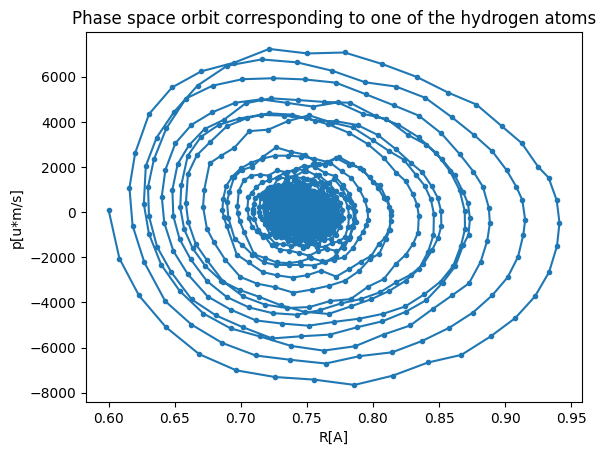

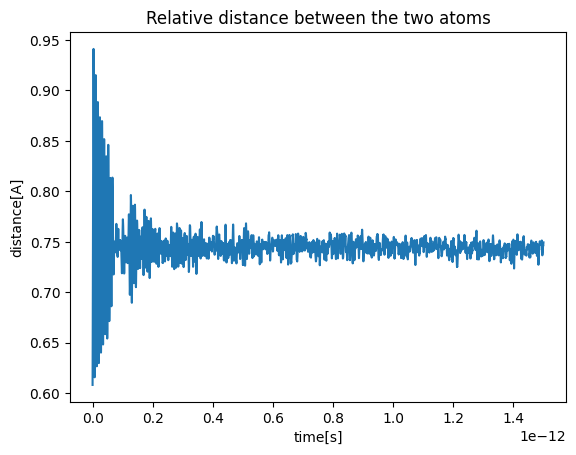

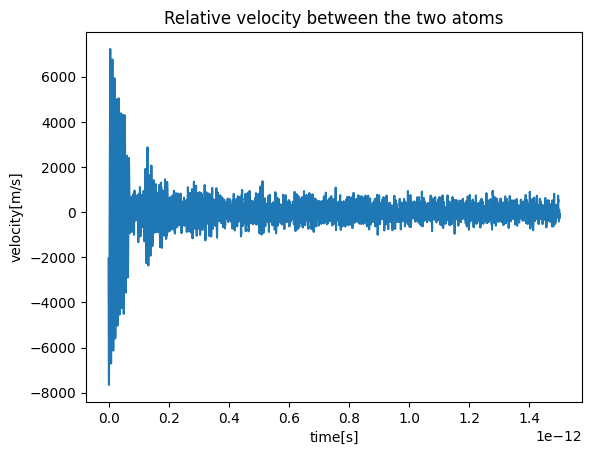

In [4]:
femto = 1.0e-15
dt = 0.2*femto
u = 1.67e-27
mass_0 = u
mass_1 = u
mass = np.array([mass_0, mass_1])
times1 = np.arange(0*femto, 1500.0*femto, dt)
coords_np1 = np.array(coords_full)
velocity_np1 = np.array(velocity_full)
momentum_np1 = mass*velocity_full

dist1 = coords_np1[:,1]-coords_np1[:,0]
v1 = velocity_np1[:,0]
m1 =momentum_np1[:,0]/u

plt.plot(dist1, m1, marker='.')
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*m/s]")
# plt.legend()
plt.show()

plt.plot(times1, dist1[1:])
plt.title('Relative distance between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('distance[A]')
plt.show()

plt.plot(times1, v1[1:])
plt.title('Relative velocity between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('velocity[m/s]')
plt.show()

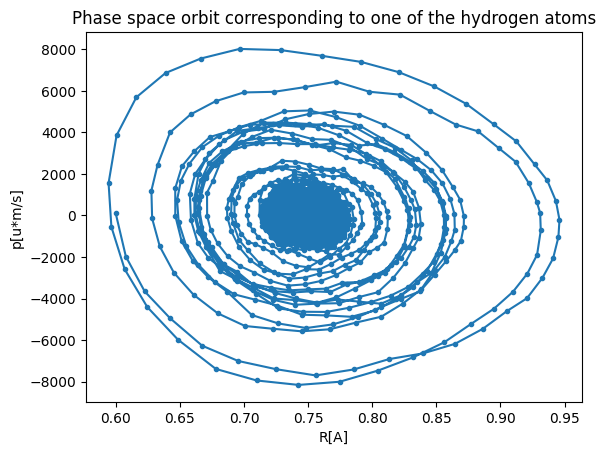

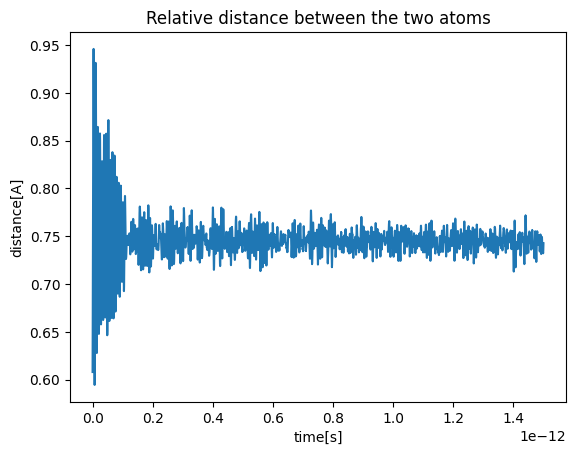

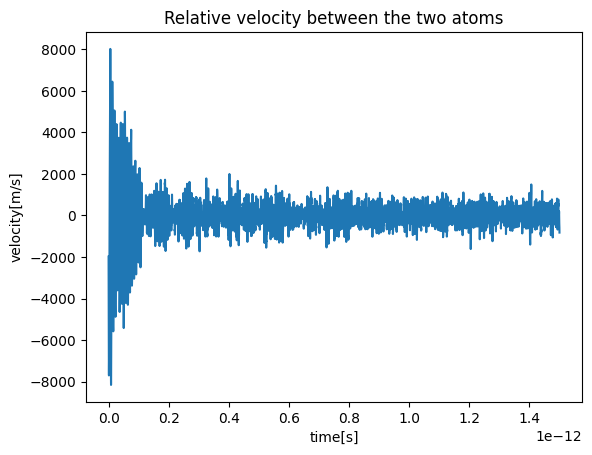

In [5]:
times2 = np.arange(0*femto, 1500.0*femto, dt)
coords_np2 = np.array(coords_diag)
velocity_np2 = np.array(velocity_diag)
momentum_np2 = mass*velocity_diag

dist2 = coords_np2[:,1]-coords_np2[:,0]
v2 = velocity_np2[:,0]
m2 =momentum_np2[:,0]/u

plt.plot(dist2, m2, marker='.')
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*m/s]")
# plt.legend()
plt.show()

plt.plot(times2, dist2[1:])
plt.title('Relative distance between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('distance[A]')
plt.show()

plt.plot(times2, v2[1:])
plt.title('Relative velocity between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('velocity[m/s]')
plt.show()

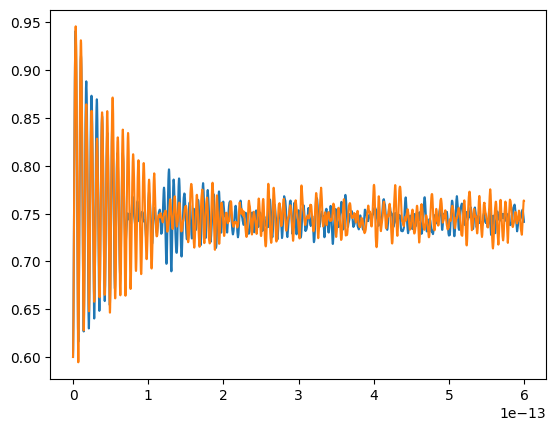

In [26]:
plt.plot(times1[:3000], dist1[:3000])
plt.plot(times1[:3000], dist2[:3000])

In [27]:
def calc_period(time, data):
    fdata = np.abs(np.fft.fft(data))
    fdata[0] = 0 #eliminate the 0th order peak
    nt = time.size
    freq = np.fft.fftfreq(nt, d=dt)
    ind = np.argmax(fdata)
    freq0 = np.abs(freq[ind])
    period = 1/freq0
    steps = int(period/dt)
    return steps, freq, fdata

34


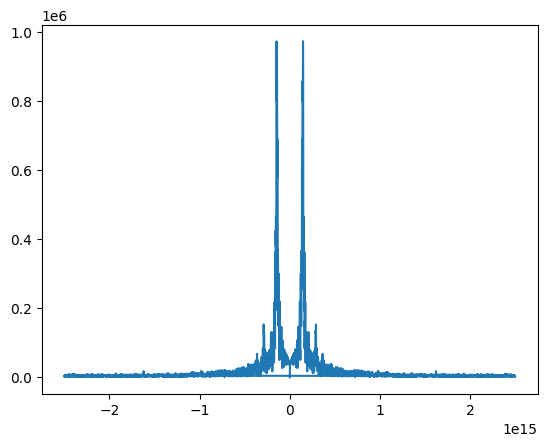

In [31]:
steps, freq, fdata = calc_period(times1[:3000], v1[:3000])
print(steps)
plt.plot(freq, fdata)
plt.show()

34


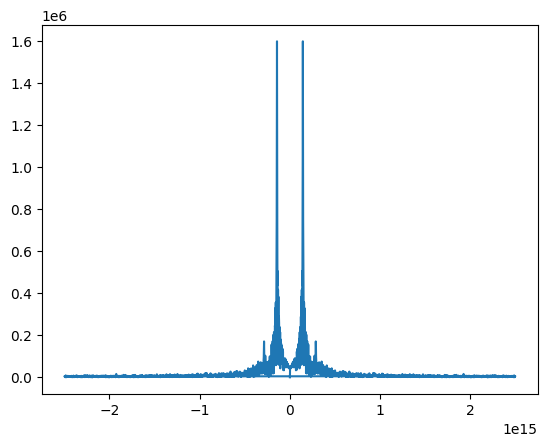

In [32]:
steps, freq, fdata = calc_period(times2[:3000], v2[:3000])
print(steps)
plt.plot(freq, fdata)
plt.show()

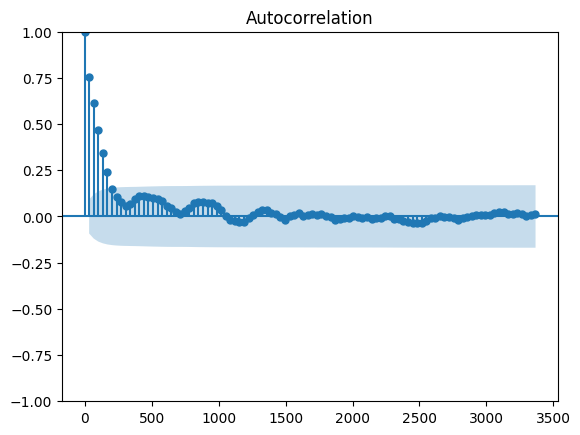

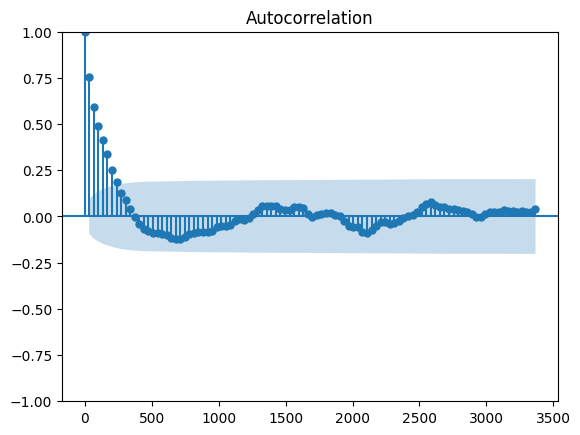

In [33]:
plot_acf(v1, lags=np.arange(0,3400,34), alpha=0.1)
plot_acf(v2, lags=np.arange(0,3400,34), alpha=0.1)
plt.show()

In [40]:
n_dof = 1
k_b = 1.38065e-23

v_sample1 = np.array(velocity_full[5000:])
kin_eng1 = np.sum(v_sample1**2*mass/2, axis=1)
k_T1 = 2*np.sum(kin_eng1)/len(v_sample1)/n_dof

v_sample2 = np.array(velocity_diag[5000:])
kin_eng2 = np.sum(v_sample2**2*mass/2, axis=1)
k_T2 = 2*np.sum(kin_eng2)/len(v_sample2)/n_dof
print('Full covariance matrix: %f. Diagonal covariance matrix: %f'%(k_T1/k_b, k_T2/k_b))

Full covariance matrix: 20.024143. Diagonal covariance matrix: 44.467794


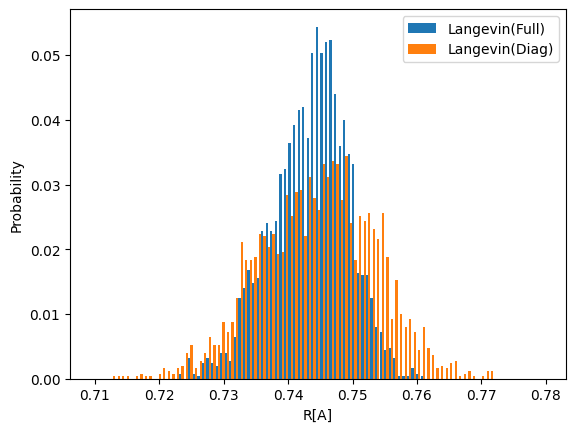

In [44]:
import pandas as pd
bins1 = np.linspace(0.71, 0.78,100)
prob1 = pd.cut(dist1[5000:],bins1)
langevin1 = pd.value_counts(prob1, normalize=True).sort_index()
distr_langevin1 = []
for value in langevin1:
    distr_langevin1.append(value)
    
prob2 = pd.cut(dist2[5000:],bins1)
langevin2 = pd.value_counts(prob2, normalize=True).sort_index()
distr_langevin2 = []
for value in langevin2:
    distr_langevin2.append(value)
    
width = 0.00035
plt.bar(np.array(bins1[:-1])-width/2, np.array(distr_langevin1),width=width, label="Langevin(Full)")
plt.bar(np.array(bins1[:-1])+width/2, np.array(distr_langevin2),width=width, label="Langevin(Diag)")
plt.xlabel("R[A]")
plt.ylabel("Probability")
plt.legend()
plt.show()

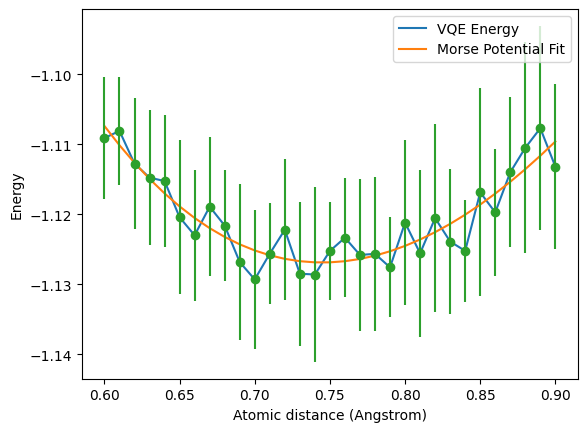

In [45]:
#VQE qasm simulator, sampled 20 times
from scipy.optimize import curve_fit
distances = np.arange(0.6, 0.9, 0.01)
vqe_potential = np.loadtxt('../qasm_vqe_eng.txt')
vqe_mean = np.mean(vqe_potential, axis=0)
vqe_err = np.std(vqe_potential, axis=0)

# distances = np.arange(0.7, 0.8, 0.005)
# vqe_potential = np.loadtxt('sv_vqe_eng.txt')

def morse_potential(r, c, m, req):
    return c*(np.exp(-2*m*(r-req))-2*np.exp(-m*(r-req)))

poptmp, pcovmp = curve_fit(morse_potential, distances, vqe_mean)
# poptmp, pcovmp = curve_fit(morse_potential, distances, vqe_potential)
vqe_pred = [morse_potential(i, poptmp[0], poptmp[1], poptmp[2]) for i in distances]

plt.plot(distances, vqe_mean, label="VQE Energy")
plt.plot(distances, vqe_pred, label="Morse Potential Fit")
plt.errorbar(distances, vqe_mean, yerr = vqe_err, fmt ='o')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [48]:
c = poptmp[0] #Ha
m = poptmp[1] #angst^-1
req = poptmp[2] #angst
Ha = 4.36e-18
kb = k_b/Ha

def func(r, tem, amp):
    return amp*np.exp(-(c*(np.exp(-2*m*(r-req))-2*np.exp(-m*(r-req)))+c)/(kb*tem))

In [49]:
poptstat1, pcovstat1 = curve_fit(func, bins1[1:], distr_langevin1)
distr_pred1 = [func(i, poptstat1[0], poptstat1[1]) for i in bins1]

poptstat2, pcovstat2 = curve_fit(func, bins1[1:], distr_langevin2)
distr_pred2 = [func(i, poptstat2[0], poptstat2[1]) for i in bins1]

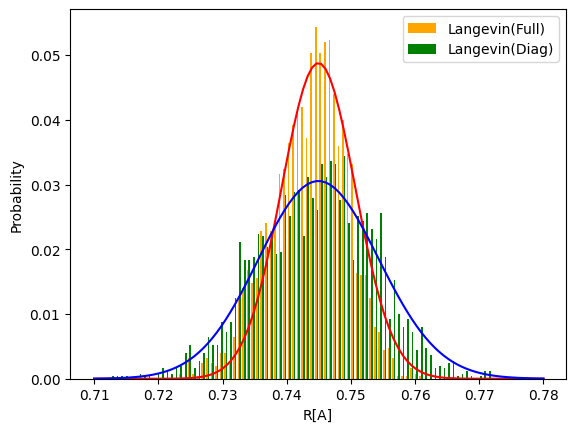

In [57]:
width = 0.00025
plt.bar(np.array(bins1[:-1])-width/2, np.array(distr_langevin1),width=width, color='orange', label="Langevin(Full)")
plt.bar(np.array(bins1[:-1])+width/2, np.array(distr_langevin2),width=width, color='green', label="Langevin(Diag)")
plt.plot(np.array(bins1), np.array(distr_pred1), color='red')
plt.plot(np.array(bins1), np.array(distr_pred2), color='blue')
plt.xlabel("R[A]")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [58]:
print('Full covariance matrix: %f. Diagonal covariance matrix: %f'%(poptstat1[0], poptstat2[0]))

Full covariance matrix: 16.991542. Diagonal covariance matrix: 45.239939
